# Normalizing flows: parameter estimation using Optim and ForwardDiff

## Load packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278


## Generate data

In [2]:
function generate_data(nr_samples::Int64, model::CompiledFlowModel)

    # specify latent sampling distribution
    dist = MvNormal([1.5, 0.5], I)

    # sample from the latent distribution
    x = rand(dist, nr_samples)

    # transform data
    y = zeros(Float64, size(x))
    for k = 1:nr_samples
        y[:,k] .= forward(model, x[:,k])
    end

    # return data
    return y, x

end;

In [3]:
model = FlowModel(2,
                  (
                      AdditiveCouplingLayer(PlanarFlow(); permute=false),
                      AdditiveCouplingLayer(PlanarFlow(); permute=false)
                  )
                )   
data_model = compile(model, [5.0, -5.0, 5.0, -5.0, 5.0, 1.0])
data_y, data_x = generate_data(1000, data_model);

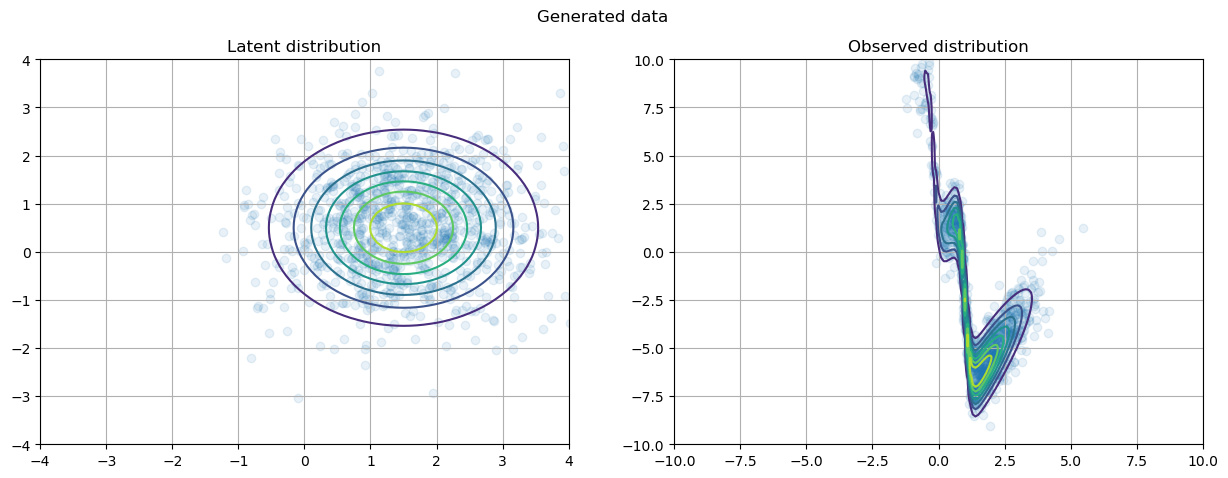

In [4]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1)
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))))
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[1].grid(), ax[2].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10)
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed distribution");

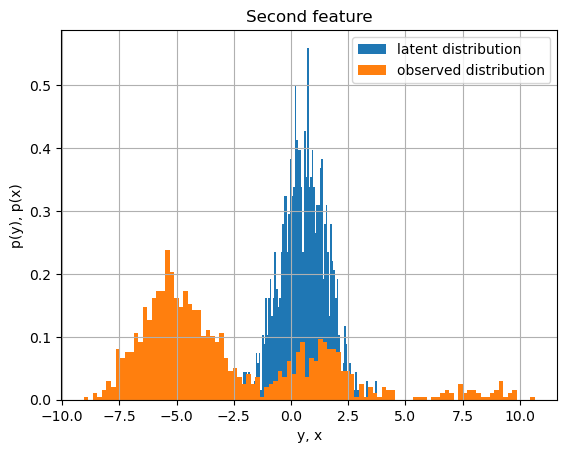

In [5]:
plt.hist(data_x[2,:], bins=100, density=true, alpha=1.0, label="latent distribution")
plt.hist(data_y[2,:], bins=100, density=true, alpha=1.0, label="observed distribution")
plt.grid(), plt.legend(), plt.ylabel("p(y), p(x)"), plt.xlabel("y, x"), plt.title("Second feature");
# first feature stays the same throughout the NICE flow

## Model specification

In [6]:
@model function normalizing_flow(nr_samples::Int64, params)
    
    # initialize variables
    x_lat     = randomvar(nr_samples)
    y_lat = randomvar(nr_samples)
    y     = datavar(Vector{Float64}, nr_samples)
    x     = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel(2,
        (
            AdditiveCouplingLayer(PlanarFlow(); permute=false),
            AdditiveCouplingLayer(PlanarFlow(); permute=false)
        )
    )   
    meta = FlowMeta(compile(model, params))

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat[k] ~ Flow(x_lat[k]) where { meta = meta }

        # specify observations
        y[k] ~ MvNormalMeanCovariance(y_lat[k], 1e-3*diagm(ones(2)))

    end

    # return variables
    return x_lat, x, y_lat, y

end;

## Probabilistic Inference

In [7]:
function inference_flow(data_y::Array{Array{Float64,1},1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat, y) = normalizing_flow(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [8]:
function f(params)
    fe = inference_flow([data_y[:,k] for k=1:size(data_y,2)], [data_x[:,k] for k=1:size(data_x,2)], params)
    return fe
end;

## Experimental validation

In [9]:
res = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.172988e+07     2.207848e+06
 * time: 0.004000186920166016
     1     5.442249e+06     3.045857e+06
 * time: 1.695000171661377
     2     3.913470e+06     3.634260e+05
 * time: 2.052000045776367
     3     3.605172e+06     2.591494e+05
 * time: 2.621999979019165
     4     3.473401e+06     5.814145e+05
 * time: 3.244000196456909
     5     3.007907e+06     8.404034e+04
 * time: 3.8470001220703125
     6     1.868375e+06     8.474142e+04
 * time: 4.68500018119812
     7     1.507747e+06     2.648561e+05
 * time: 5.945000171661377
     8     1.505756e+06     2.983748e+05
 * time: 6.337000131607056
     9     1.388697e+06     2.795928e+05
 * time: 6.903000116348267
    10     7.045296e+05     2.998774e+05
 * time: 7.881999969482422
    11     2.540867e+05     8.533597e+04
 * time: 8.680999994277954
    12     2.281870e+05     8.845954e+04
 * time: 9.08400011062622
    13     8.118240e+04     1.369994e+05
 * time: 9.696000099182129
    1

 * Status: success

 * Candidate solution
    Final objective value:     -3.684410e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.56e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.91e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-12 ≰ 0.0e+00
    |g(x)|                 = 1.50e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   20  (vs limit Inf)
    Iterations:    32
    f(x) calls:    101
    ∇f(x) calls:   101


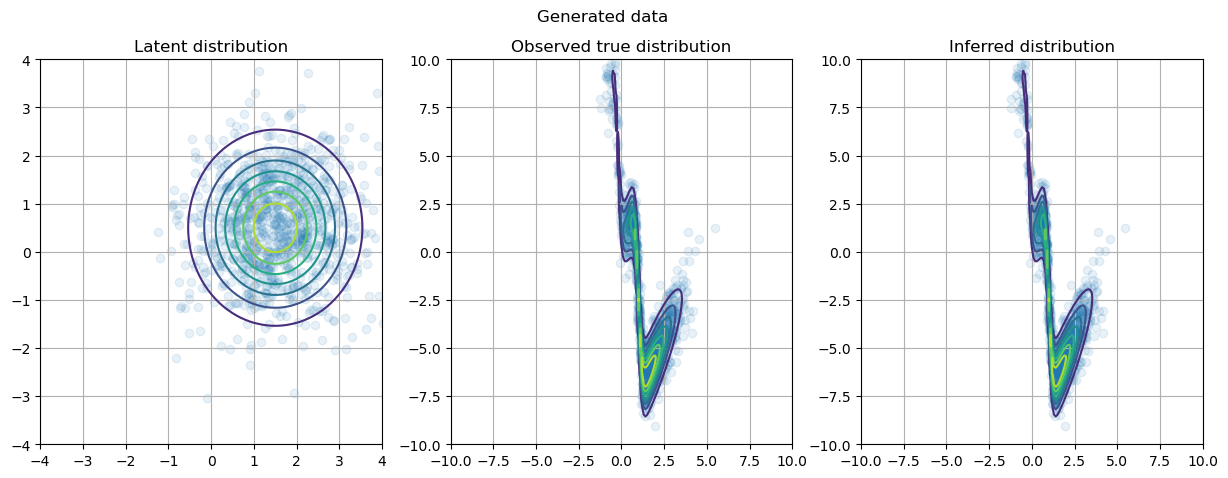

In [10]:
params = Optim.minimizer(res)
inferred_model = compile(model, params)
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1)
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))))
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[3].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[3].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(inferred_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10), ax[3].set_xlim(-10,10), ax[3].set_ylim(-10,10)
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed true distribution"), ax[3].set_title("Inferred distribution");

In [11]:
params

6-element Array{Float64,1}:
 -4.999026976530986
  5.00682070510651
 -5.0064528883891555
  5.000487429399144
 -4.988888069236088
 -0.9981087519201606